<center><h1><font color='lightblue' style="background-color:black;font-family: sans-serif; font-size:150%;" ><b>Twitter Sentiment Analysis</b></font></h1></center>


<p><center><b>Tweet Sentiment Analysis refers to process of determining the emotional tone sentiment expressed in tweet.</b></center></p>

<img src="https://analyticslearn.com/wp-content/uploads/Sentiment-Analysis-for-Twitter-What-It-Is-and-How-to-Do-It-1-1024x576.png">


<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Importing Libraries</b></font></h1>

In [1]:
!pip install emoji

In [2]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd

# data visulization
import seaborn as sns
import matplotlib.pyplot as plt

# text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer

# remove emoji
import emoji

# regular expression
import re

# wordcloud
from wordcloud import WordCloud
from collections import Counter

# model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Load Data</b></font></h1>

In [4]:
# load data
cols=['tweetid', 'entity', 'target', 'content']

data0 = pd.read_csv("twitter_training.csv",names=cols)
data1 = pd.read_csv("twitter_validation.csv",names=cols)

final_df = pd.concat([data0,data1])

In [5]:
final_df.head()

,tweetid,entity,target,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
# data dimension
final_df.shape

(75682, 4)

In [7]:
# info about data
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweetid  75682 non-null  int64 
 1   entity   75682 non-null  object
 2   target   75682 non-null  object
 3   content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [8]:
# check null values
final_df.isna().sum()

tweetid      0
entity       0
target       0
content    686
dtype: int64

In [9]:
# drop null values
final_df.dropna(inplace=True)

In [10]:
# check duplicates values
final_df.duplicated().sum()

2857

In [11]:
# drop duplicates
final_df.drop_duplicates(inplace=True)

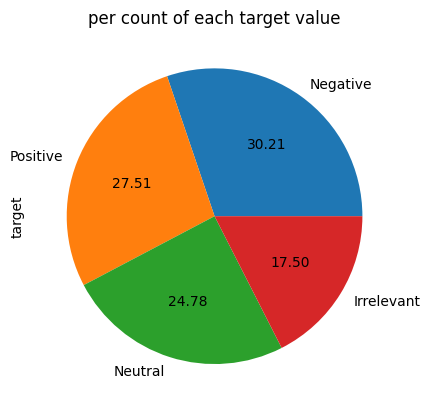

In [12]:
# value count of target col
final_df['target'].value_counts().plot(kind='pie',autopct='%.2f')
plt.title("per count of each target value")
plt.show()

In [13]:
target_cou = final_df['target'].value_counts().reset_index()
target_cou

,index,target
0,Negative,21790
1,Positive,19846
2,Neutral,17879
3,Irrelevant,12624


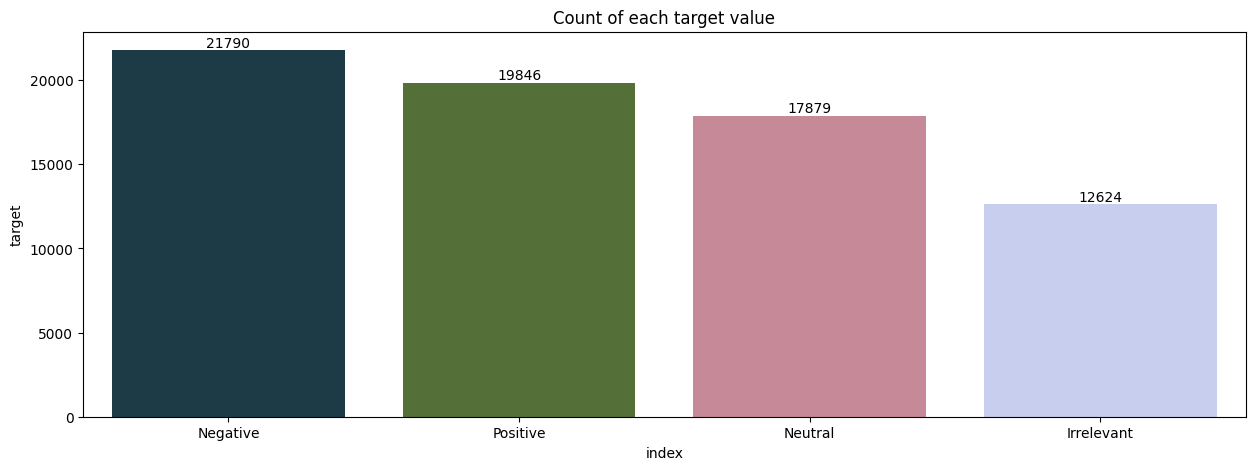

In [14]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=target_cou,x='index',y='target',palette='cubehelix')
for bars in ax.containers:
    ax.bar_label(bars)
    
plt.title("Count of each target value")    
plt.show()

In [15]:
# tweet count of each user
tweet_count = final_df.groupby('tweetid')['target'].count().sort_values(ascending=False).reset_index()
tweet_count = tweet_count.rename(columns={'target':'count'})
tweet_count

,tweetid,count
0,8371,7
1,8846,7
2,2752,7
3,10429,7
4,2131,7
...,...,...
12442,4717,2
12443,5647,2
12444,5603,2
12445,3108,2


<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Feature engineering</b></font></h1>

In [16]:
# char count 
final_df['char_count'] = final_df['content'].apply(len)
# word count 
final_df['word_count'] = final_df['content'].apply(lambda x:len(nltk.word_tokenize(x)))
# sentence count
final_df['sent_count'] = final_df['content'].apply(lambda x:len(nltk.sent_tokenize(x)))

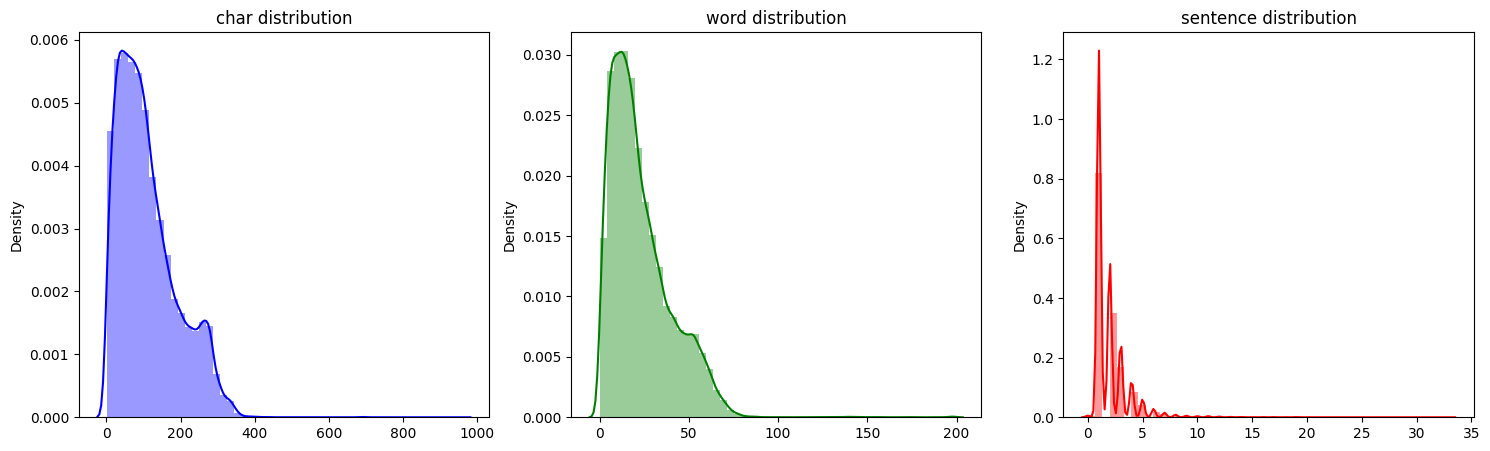

In [17]:
# dist plot

fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.distplot(ax=axes[0],x=final_df['char_count'],color='b')
axes[0].set_title('char distribution')

sns.distplot(ax=axes[1],x=final_df['word_count'],color='g')
axes[1].set_title('word distribution')

sns.distplot(ax=axes[2],x=final_df['sent_count'],color='r')
axes[2].set_title('sentence distribution')
plt.show()

In [18]:
# drop unnecessary cols
final_df = final_df.drop(columns=['tweetid','entity'],axis=1)

In [19]:
final_df.head()

,target,content,char_count,word_count,sent_count
0,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


In [20]:
# remove emojis from tweets
final_df['content'] = final_df['content'].apply(lambda x: emoji.replace_emoji(x,replace=''))

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Text Preprocessing</b></font></h1>

<b><font color='grey'>- lowercase</font></b><br>
<b><font color='grey'>- remove punctuation</font></b><br>
<b><font color='grey'>- remove stopwords</font></b><br>
<b><font color='grey'>- steaming</font></b>

In [21]:
# function for text preprocessing
ps = PorterStemmer()

def preprocessing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    full_txt = []
    for i in text:
        if i not in string.punctuation and i not in stopwords.words('english'):
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)

In [22]:
final_df['content'] = final_df['content'].apply(preprocessing)

In [23]:
final_df.head()

,target,content,char_count,word_count,sent_count
0,Positive,im get borderland murder,53,11,1
1,Positive,come border kill,51,13,1
2,Positive,im get borderland kill,50,11,1
3,Positive,im come borderland murder,51,11,1
4,Positive,im get borderland 2 murder,57,13,1


In [24]:
final_df.duplicated().sum()

2963

In [25]:
final_df = final_df.drop_duplicates()

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>EDA</b></font></h1>

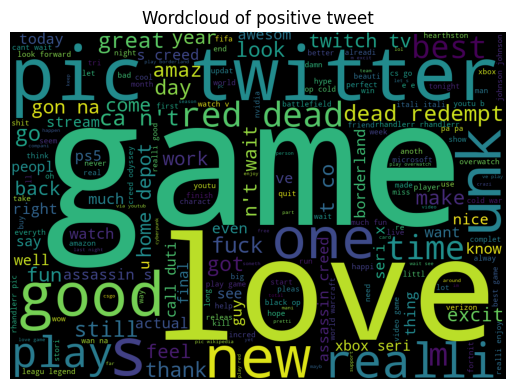

In [26]:
# word cloud for positive tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
positive = wc.generate(final_df[final_df['target']=='Positive']['content'].str.cat(sep=" "))
plt.title('Wordcloud of positive tweet')
plt.axis('off')
plt.imshow(positive)
plt.show()

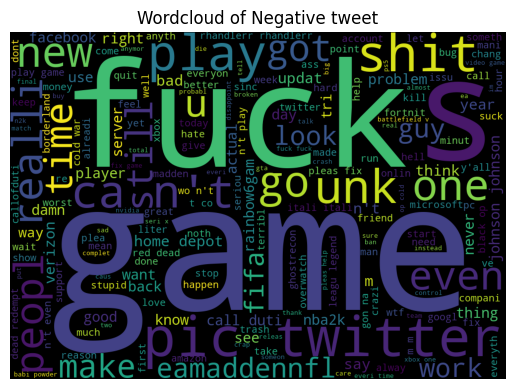

In [27]:
# word cloud for negative tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
negative = wc.generate(final_df[final_df['target']=='Negative']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Negative tweet')
plt.axis('off')
plt.imshow(negative)
plt.show()

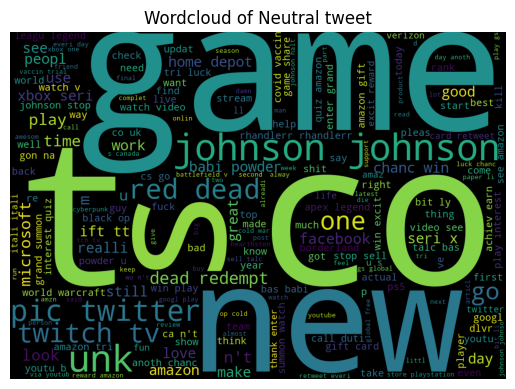

In [28]:
# word cloud for neutral tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
neutral = wc.generate(final_df[final_df['target']=='Neutral']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Neutral tweet')
plt.axis('off')
plt.imshow(neutral)
plt.show()

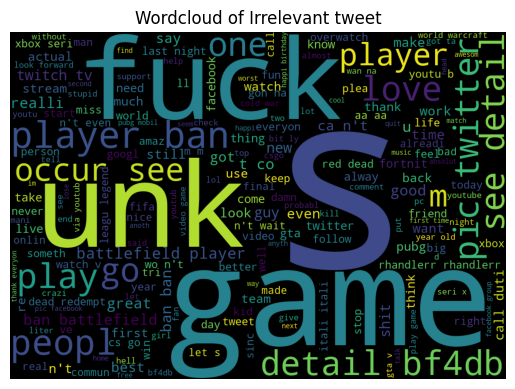

In [29]:
# word cloud for irrelevant tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
irrelevant = wc.generate(final_df[final_df['target']=='Irrelevant']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Irrelevant tweet')
plt.axis('off')
plt.imshow(irrelevant)
plt.show()

In [30]:
def pre(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    return text

In [31]:
final_df['content'] = final_df['content'].apply(pre)

In [32]:
final_df.duplicated().sum()

156

In [33]:
final_df = final_df.drop_duplicates()

In [34]:
# most common words in positive tweets
positive = []
for txt in final_df[final_df['target']=='Positive']['content'].tolist():
    for word in txt.split():
        positive.append(word)

In [35]:
len(positive)

196052

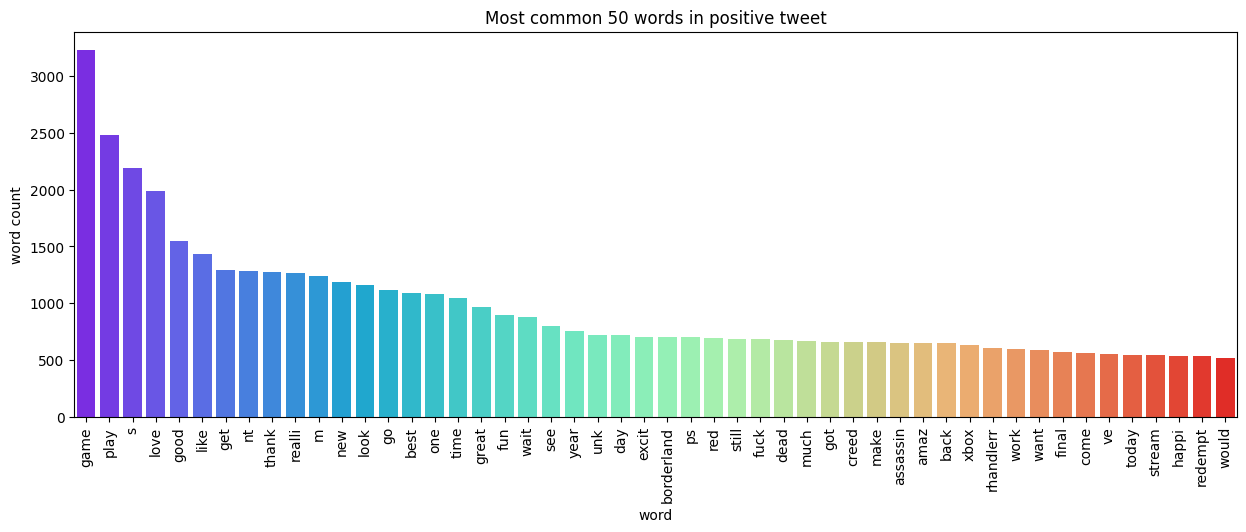

In [36]:
# plot most 50 common words from positive tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(positive).most_common(50))[0],y=pd.DataFrame(Counter(positive).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in positive tweet')
plt.xticks(rotation=90)
plt.show()

In [37]:
# most common words in negative tweets
negative = []
for txt in final_df[final_df['target']=='Negative']['content'].tolist():
    for word in txt.split():
        negative.append(word)

In [38]:
len(negative)

244563

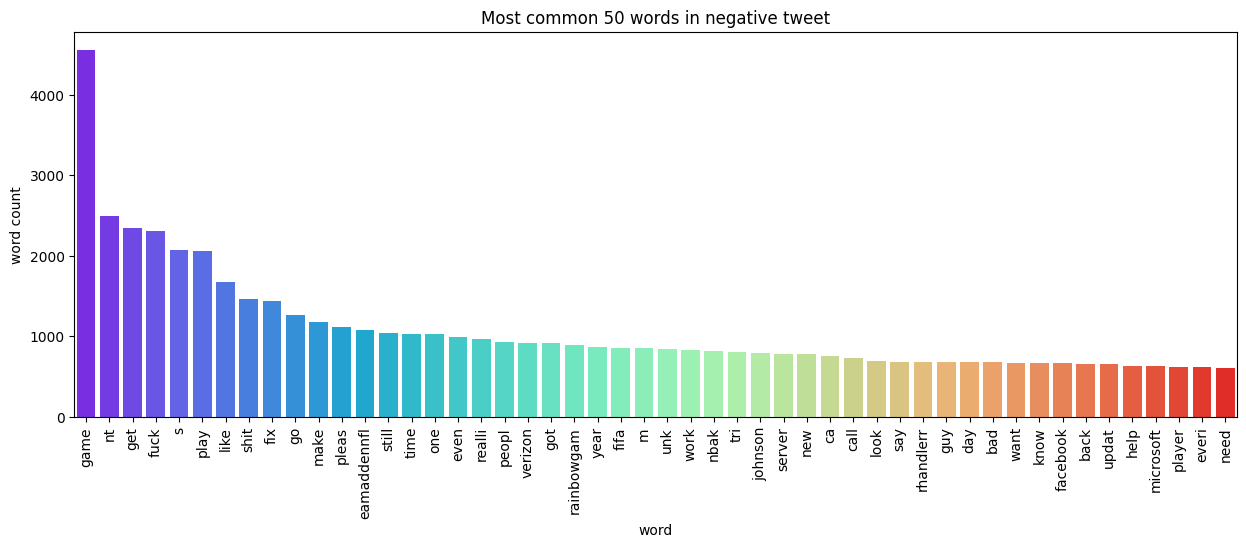

In [39]:
# plot most 50 common words from negative tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(negative).most_common(50))[0],y=pd.DataFrame(Counter(negative).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in negative tweet')
plt.xticks(rotation=90)
plt.show()

In [40]:
# most common words in neutral tweets
neutral = []
for txt in final_df[final_df['target']=='Neutral']['content'].tolist():
    for word in txt.split():
        neutral.append(word)

In [41]:
len(neutral)

210002

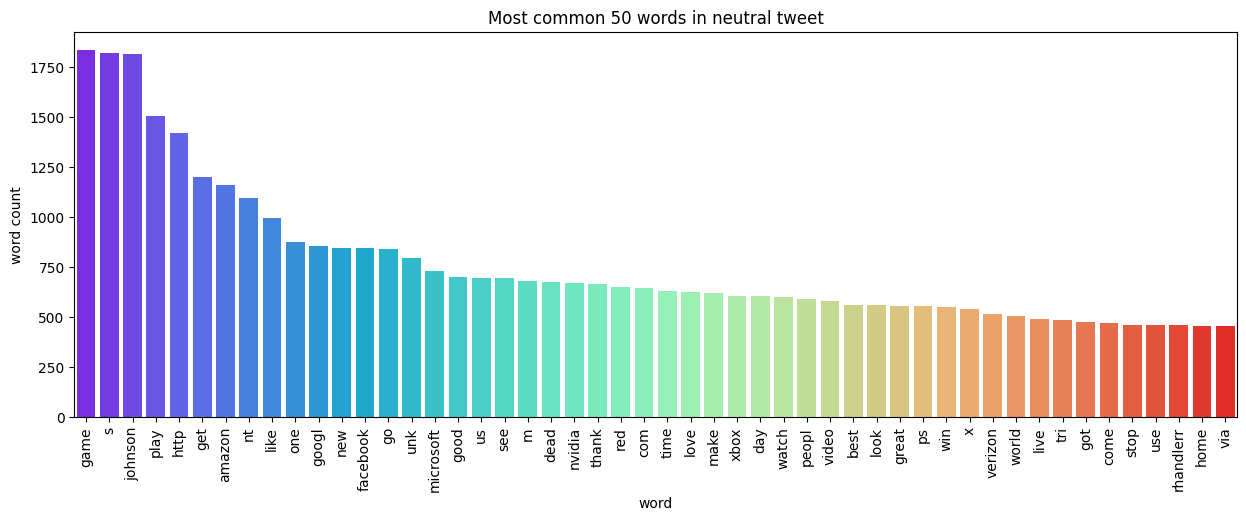

In [42]:
# plot most 50 common words from neutral tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(neutral).most_common(50))[0],y=pd.DataFrame(Counter(neutral).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in neutral tweet')
plt.xticks(rotation=90)
plt.show()

In [43]:
# most common words in irrelevant tweets
irrelevant = []
for txt in final_df[final_df['target']=='Irrelevant']['content'].tolist():
    for word in txt.split():
        irrelevant.append(word)

In [44]:
len(irrelevant)

138683

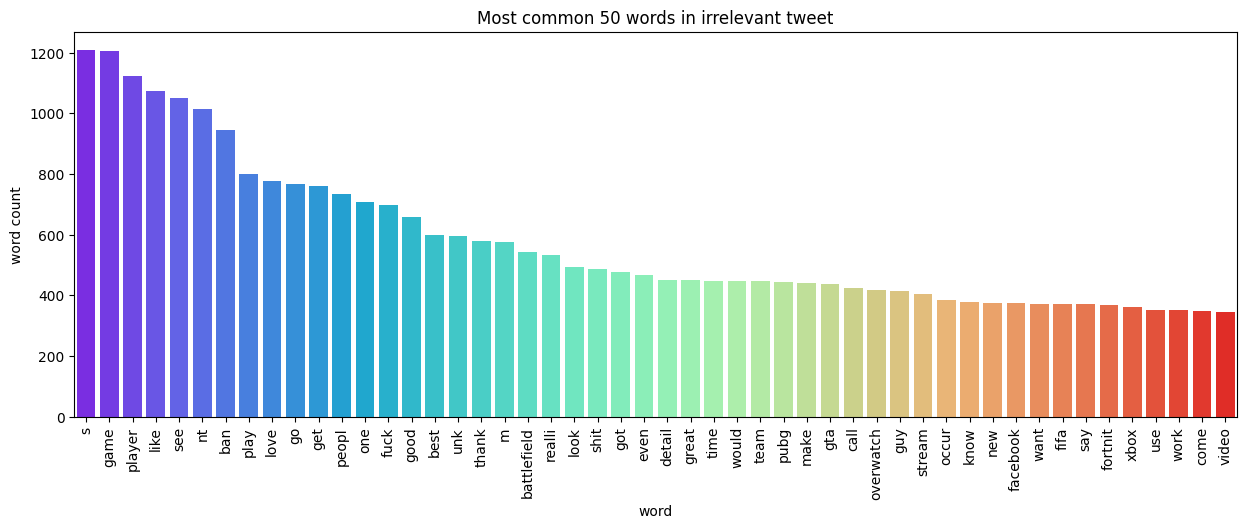

In [45]:
# plot most 50 common words from irrelevant tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(irrelevant).most_common(50))[0],y=pd.DataFrame(Counter(irrelevant).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in irrelevant tweet')
plt.xticks(rotation=90)
plt.show()

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Label Encoding</b></font></h1>

In [46]:
# Positive - 1
# Negative - 0
# Neutral - 2
# Irrelevant - 3

final_df['sentiment'] = final_df['target'].replace({'Positive':1,'Negative':0,'Neutral':2,'Irrelevant':3})

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Extract Input and Target data</b></font></h1>

In [47]:
X = final_df['content']
y = final_df['sentiment']

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Spliting data</b></font></h1>

In [48]:
# split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Pipeline</b></font></h1> 

In [49]:
# step-1 convert text data into numeric 
# step-2 apply RandomForestClassifier 


sentiment_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('rfc',RandomForestClassifier(random_state=42))
])

In [50]:
# fit the data into pipeline
sentiment_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(random_state=42))])

<h1><font color='blue' style="background-color:black;font-family: sans-serif;"><b>Model Evaluation</b></font></h1> 

In [51]:
y_pred = sentiment_pipeline.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9203129527673138


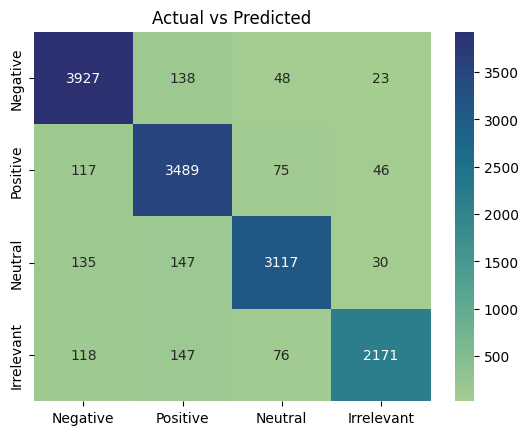

In [52]:
# Positive - 1
# Negative - 0
# Neutral - 2
# Irrelevant - 3

label = ['Negative','Positive','Neutral','Irrelevant']
sns.heatmap(confusion_matrix(y_test,y_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.title('Actual vs Predicted')
plt.show()

In [53]:
mnb_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('mnb',MultinomialNB())
])

In [54]:
mnb_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [55]:
mnb_pred = mnb_pipeline.predict(X_test)
print(accuracy_score(y_test,mnb_pred))

0.7037815126050421


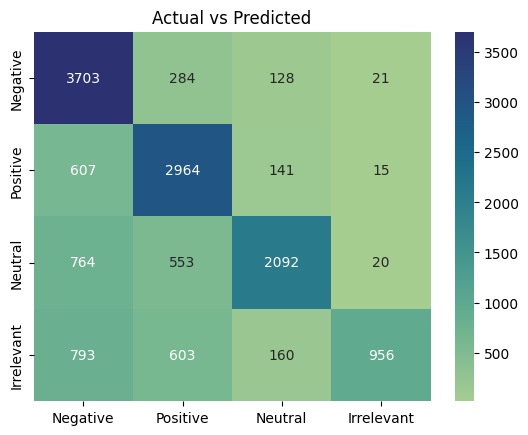

In [56]:
label = ['Negative','Positive','Neutral','Irrelevant']
sns.heatmap(confusion_matrix(y_test,mnb_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.title('Actual vs Predicted')
plt.show()

In [57]:
lr_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression(penalty=None,solver='sag',max_iter=500))
])

In [58]:
lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr',
                 LogisticRegression(max_iter=500, penalty=None, solver='sag'))])

In [59]:
lr_pred = lr_pipeline.predict(X_test)
print(accuracy_score(y_test,lr_pred))

0.8196175021732831


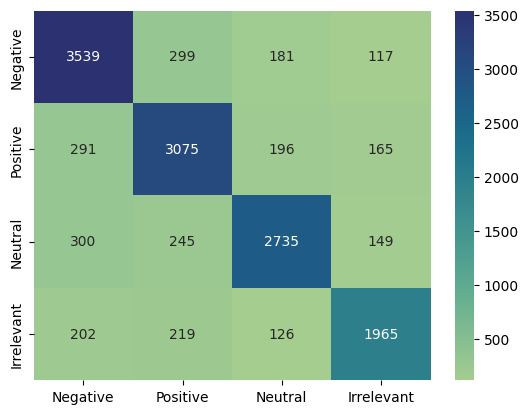

In [60]:
label = ['Negative','Positive','Neutral','Irrelevant']

sns.heatmap(confusion_matrix(y_test,lr_pred),xticklabels=label,yticklabels=label,annot=True,fmt='d',cmap='crest')
plt.show()

In [61]:
import pickle 
pickle.dump(sentiment_pipeline,open('rfc_sentiment_model','wb'))

In [62]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(sentiment_pipeline, X_train, y_train, cv=5)
# scores